# Quantum Approximate Optimization Algorithm using Gate-based QC

This notebook implements Quantum Approximate Optimization Algorithm (QAOA) on a gate-based Quantum Computing model.

## Importing required libraries

In [1]:
# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Library for Graphs
import networkx as nx

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize
from collections import Counter

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml

## **Maximal Independent Set** (MIS)

### *Definition*

For a graph $G = (V, E)$, an independent set $S$ is a ***Maximal Independent Set*** if for $v \in V$, one of the following is true:

1. $v \in S$
2. $N(v) \cap S \neq \emptyset$ where $N(v)$ denotes the neighbors of $v$
 
The above can be restated as a vertex either belongs to the independent set or has at least one neighbor vertex that belongs to the independent set. As a result, every edge of the graph has at least one endpoint not in $S$. However, it is not true that every edge of the graph has at least one, or even one endpoint in $S$

> Notice that any neighbor to a vertex in the independent set $S$ cannot be in $S$ because these vertices are disjoint by the independent set definition.

### *Cost Function*

I will use the cost function as given in [Boros 2002](https://www.sciencedirect.com/science/article/pii/S0166218X01003419), 

\begin{equation}\tag{1}
C(X) = \sum_{i \in V} x_j - \sum_{(i,j) \in E} x_i x_j. 
\end{equation}

Where the $X = (x_1, \dots, x_n)$ and it denotes if the vertex $v_i$ is in $S$. We want to find $S$ such that it ***maximizes*** $C(X)$.

### QUBO formulation for MIS

Quadratic Unconstrained Binary Optimization (QUBO) problems are a class of combinatorial optimization problems that in general are NP-hard. QUBO's can be defined by a real vector $c$, matrix $Q$ and function $f_Q: \mathbb{B}^n\rightarrow\mathbb{R}$ where $Q$ is an upper triangular $(n \times n)$ matrix and $X$ is a binary vector $X \in \{0,1\}^n$ whose length is $n$, the function is defined as,

\begin{equation}\tag{2}
f_Q(X) = x^\top Qx + c^T x= \sum_{j, i=1}^n Q_{ij} x_i x_j + \sum_{i=1}^n c_i x_i.
\end{equation}


Usually QUBO's are defined as a minimization problem, but we can change the sign of our function to convert it into a maximization problem. To convert the **MIS** problem into the QUBO form we need to find $Q$ and $c$. We can easily do this by comparing both the functions in (1) and (2). Comparing, we find that,
\begin{align}\tag{3a}
Q_ij = x_i x_j, \\ 
c_i = -x_i \tag{3b}.
\end{align}

> The signs are flipped because we want to maximize $C$.

# Quantum Approximate Optimization Algorithm (QAOA)

We have formulated MIS as a QUBO problem, and we are on track to solve this optimization problem, but we still need to take certain steps to perform QAOA. From here on out I will describe further steps we need to take to perform QAOA.

## Mapping to a Hamiltonian

QUBO's can be mapped to a Hamiltonian which can be implemented on a Quantum Computer. This mapping is usually done to an Ising Model. An example map is $x_i \rightarrow \frac{Z_i - 1}{2}$, which maps a binary variable $x_i$ to Pauli spin $Z_i$. We can use this map in (2) to get the Cost Hamiltonian $H_C$, 

\begin{equation}\tag{4}
    H_C =  \sum_{i,j}^{n} \frac{1}{4} Q_{ij} Z_i Z_j - \sum_{j}^{n} \frac{1}{2} \left( c_i + \sum_{i}^{n} Q_{ij} \right) Z_i.
\end{equation}

Once we have the Cost Hamiltonian we can define the Mixer Hamiltonian $H_M$ as

\begin{equation}\tag{5}
    H_M = \sum_{i}^{n} X_i.    
\end{equation}


## Implementing the Hamiltonians

Once we have the Hamiltonians we must define unitaries representing the Hamiltonian's ($H_C$ and $H_M$).

\begin{align}
    \hat U_C(\gamma) &= e^{-i\gamma H_C} \tag{5a}\\
    \hat U_M(\beta) &= e^{-i\beta H_M}, \tag{5b}
\end{align}

Where $\gamma$ and $\beta$ are variational parameters of the circuit. 
We call $\hat U_C(\gamma)$ and $\hat U_M(\beta)$ the cost and mixer layers, respectively.
A single QAOA layer comprises one cost and one mixer layer, which can be further stacked to build a deeper circuit with more layers. Each element in the mixer layer can be implemented with a single rotation gate $R_X$. 

\begin{equation}\tag{6}
    \hat U_M(\beta) = e^{-i\beta H_M} = \prod_{i=1}^n R_{X_i}(2\beta)
\end{equation}

\begin{equation}\tag{7}
    \hat U_C(\gamma) = \prod_{i=1, j<i}^n R_{Z_iZ_j} \left( \frac{1}{4}Q_{ij} \gamma \right)
    \prod_{i=1}^n R_{Z_i} \left(  \frac{1}{2} \left( c_i + \sum_{j=1}^{n} Q_{ij} \right) \gamma \right)
\end{equation}

(6) and (7) are the gate decomposition of the unitaries in (5). 

## Layers

Define the total number of QAOA layers, $p \geq 1$. 
Initialize the $2p$ variational parameters ${\gamma} = (\gamma_1,\gamma_2,\ldots,\gamma_p)$ and ${\beta} = (\beta_1,\beta_2,\ldots,\beta_p)$ such that $\gamma_k \in [0,2\pi)$ and $\beta_k \in [0,\pi)$ for $k = 1, \dots, p$. 

The final state output by the circuit is, therefore, given by
    
\begin{equation}\tag{8}
  \ket{\psi_p({\gamma},{\beta})} = e^{-i\beta_p H_M} e^{-i\gamma_p H_C} \ldots e^{-i\beta_1 H_M} e^{-i\gamma_1H_C} \ket{s}.
\end{equation}

## Measurement and Expectation Value

The expectation value of the Hamiltonian $h_C$ with respect to the ansatz state $\ket{\psi_p({\gamma},{\beta})}$, which corresponds to the cost obtained by the quantum algorithm for the underlying problem, is calculated through repeated measurements of the final state in the computational basis:


\begin{equation}\tag{9}
  F_p({\gamma},{\beta}) =  \bra {\psi_p({\gamma},{\beta})} {H_C} \ket {\psi_p({\gamma},{\beta})}
\end{equation}

## Optimizer

A classical optimization algorithm is employed to iteratively update the parameters ${\gamma}$ and ${\beta}$. The goal of the aforementioned routine is to find the optimal set of parameters $({\gamma}^*,{\beta}^*)$ such that the expectation value $F_p({\gamma},{\beta})$ is maximized:

\begin{equation}\tag{10}
  ({\gamma}^*,{\beta}^*) = \arg\min_{{\gamma},{\beta}} F_p({\gamma},{\beta})
\end{equation}

In [2]:
# Defining some helper functions.
# Graph plotting function.
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")

# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]

# Plotting the resulting set S as coloring on the graph.
def plot_solution(G,pos,results):
    c = ["r" if b == "0" else "c" for b in find_most_common_solutions(results, 1)[0]]
    draw_graph(G, c, pos)

## Building the model and its Cost Function

I'm using ***docplex*** to build the model and calculate $Q$ and $c$.

In [3]:
def build_qubo(G: nx.Graph):

    n = G.number_of_nodes()
    edges = G.edges()
    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)
    Q =  -1*sum(x[v] for v in G.nodes()) + sum(x[e[0]]*x[e[1]] for e in edges)
    model.minimize(Q)   

    problem = from_docplex_mp(model)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)
    # print(qubo)

    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo

## Creating the QAOA circuit and layers.

I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

In [4]:
# Defining the Cost and the Layers of QAOA.

# Cost Layer.
def U_C(gamma,quadratics,linears,num_qubits):

    for wire in range(num_qubits):
        qml.RZ(1/2*(linears[(0, wire)]+sum(quadratics[(wire, j_wire)] for j_wire in range(num_qubits)))*gamma,wires=wire)

    for (wire1, wire2) in quadratics.keys():
        if wire1!=wire2:
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(1/4*quadratics[(wire1, wire2)]*gamma,wires=wire2)
            qml.CNOT(wires=[wire1, wire2])

# Mixer Layer.
def U_M(beta,num_qubits):
    for wire in range(num_qubits):
        qml.RX(2*beta,wires=wire)

# Function to generate the QAOA circuit given the parameters and coefficients.
def qaoa_circuit_generator(num_qubits,layers,gammas,betas,quadratics,linears):
    # Defining the QAOA circuit.
    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1024)
    @qml.qnode(dev)
    def circuit(gammas,betas,quadratics,linears):

        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)
        qml.Barrier()

        for layer in range(layers):
            U_M(betas[layer],num_qubits)
            qml.Barrier()
            U_C(gammas[layer],quadratics,linears,num_qubits)
            qml.Barrier()
        
        return qml.counts(wires=range(num_qubits))

    return circuit(gammas,betas,quadratics,linears)

In [5]:
def qaoa(G:nx.Graph,layers:int):

    quadratics, linears, qubo = build_qubo(G)
    num_qubits = G.number_of_nodes()

    # Initial guess
    init_gamma = np.array([pi/2]*layers)
    init_beta = np.array([pi/4]*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):

        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        counts = qaoa_circuit_generator(num_qubits, layers, gammas, betas, quadratics, linears)
        best_sol = max(counts, key=counts.get)
        return qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))


    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA')
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')

    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    counts = qaoa_circuit_generator(num_qubits, layers,prime_gammas, prime_betas, quadratics, linears)
    most_common_results = dict(Counter(counts).most_common(40))
    
    return most_common_results, plot_histogram(most_common_results, title='Counts',figsize=(20, 5))

## Running QAOA on for MIS. 

### Graph with 3 nodes

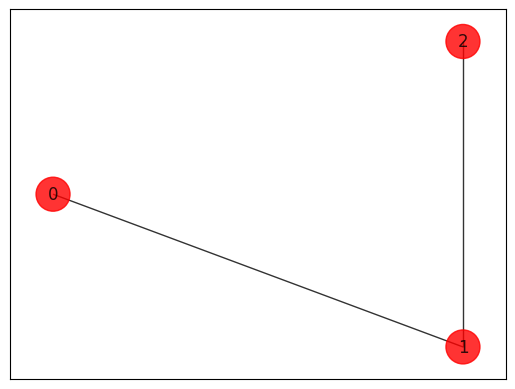

In [6]:
# Initializing a Graph Instance.

# Generating a graph of 3 nodes
# Nodes in the Graph.
n = 3  # Number of nodes in graph
G3 = nx.Graph()
G3.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0)]
G3.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G3.nodes()]
pos_3 = nx.shell_layout(G3)

draw_graph(G3, colors, pos_3)

Elapsed time for QAOA: 1.6360695362091064 seconds


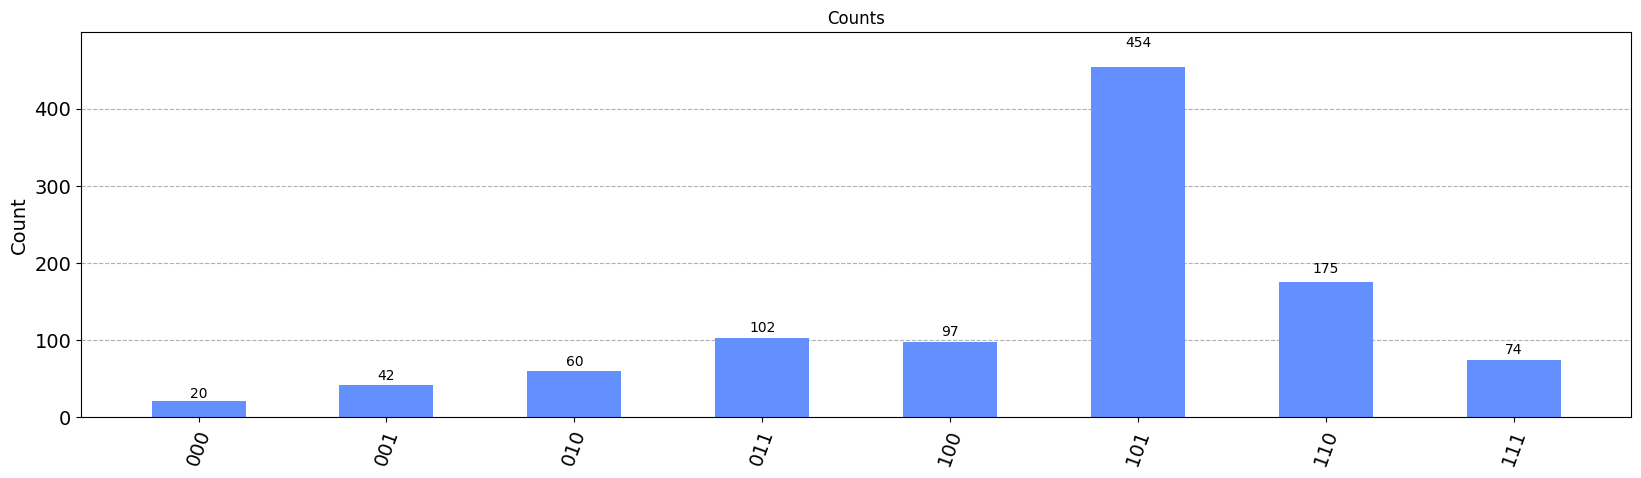

In [7]:
counts_3, hist_3 = qaoa(G3,10)
hist_3

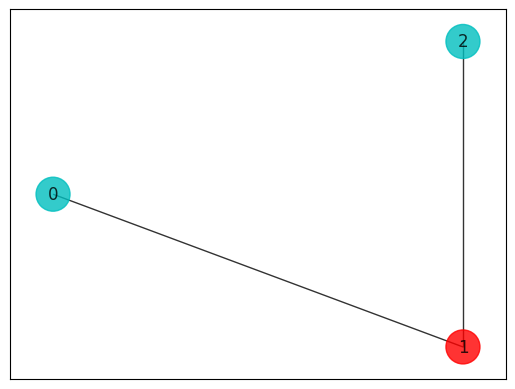

In [8]:
plot_solution(G3,pos_3,counts_3)

### Graph with 4 nodes

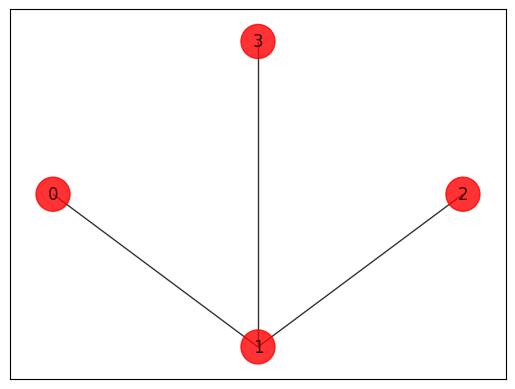

In [9]:
# Initializing a Graph Instance.

# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 4  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (1, 3, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G4.nodes()]
pos_4 = nx.shell_layout(G4)

draw_graph(G4, colors, pos_4)

Elapsed time for QAOA: 1.9488346576690674 seconds


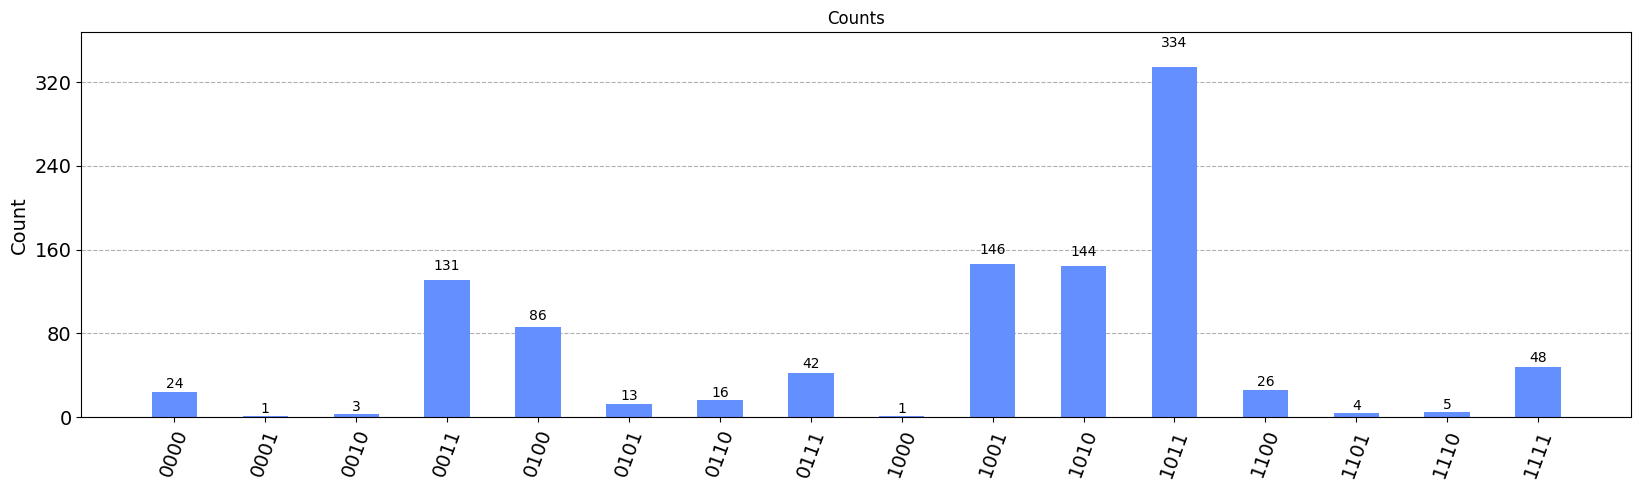

In [10]:
counts_4, hist_4 = qaoa(G4,10)
hist_4

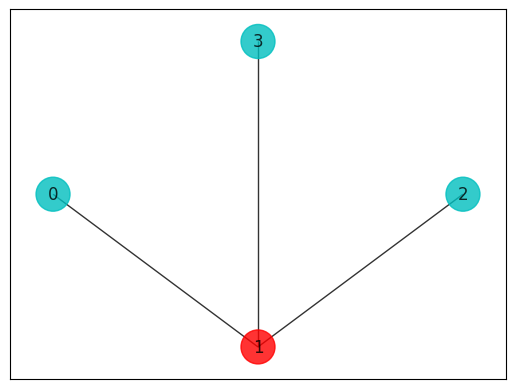

In [11]:
plot_solution(G4,pos_4,counts_4)

### Graph with 5 nodes

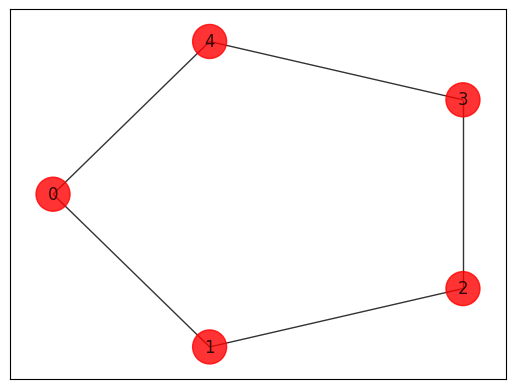

In [12]:
# Initializing a Graph Instance.

# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 5  # Number of nodes in graph
G5 = nx.Graph()
G5.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 0, 1.0)]
G5.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G5.nodes()]
pos_5 = nx.shell_layout(G5)

draw_graph(G5, colors, pos_5)

Elapsed time for QAOA: 3.350174903869629 seconds


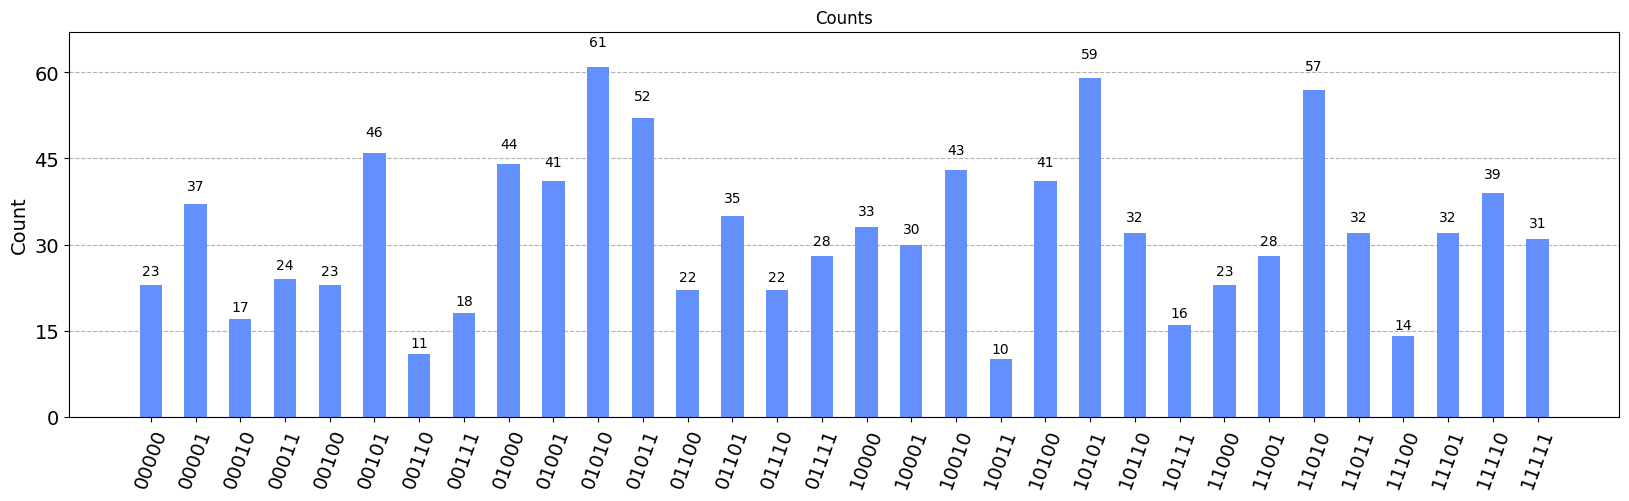

In [22]:
counts_5, hist_5 = qaoa(G5,13)
hist_5

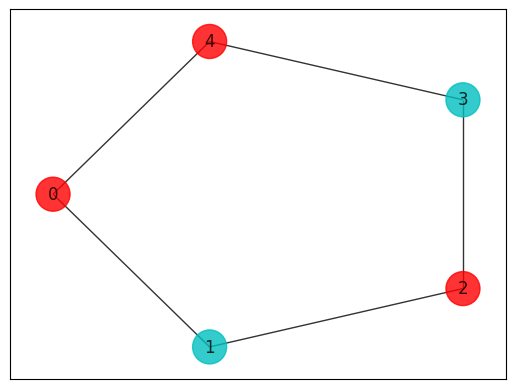

In [23]:
plot_solution(G5,pos_5,counts_5)

### Graph with 6 nodes

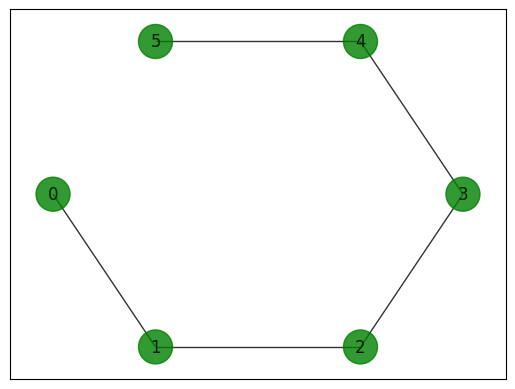

In [15]:
# Initializing a Graph Instance.

# Defining the Graph.
# Nodes in the Graph.
n = 6  
G6 = nx.Graph()
G6.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (4, 5, 1.0)]
G6.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["g" for node in G6.nodes()]
pos6 = nx.shell_layout(G6)

draw_graph(G6, colors, pos6)

Elapsed time for QAOA: 0.5116252899169922 seconds


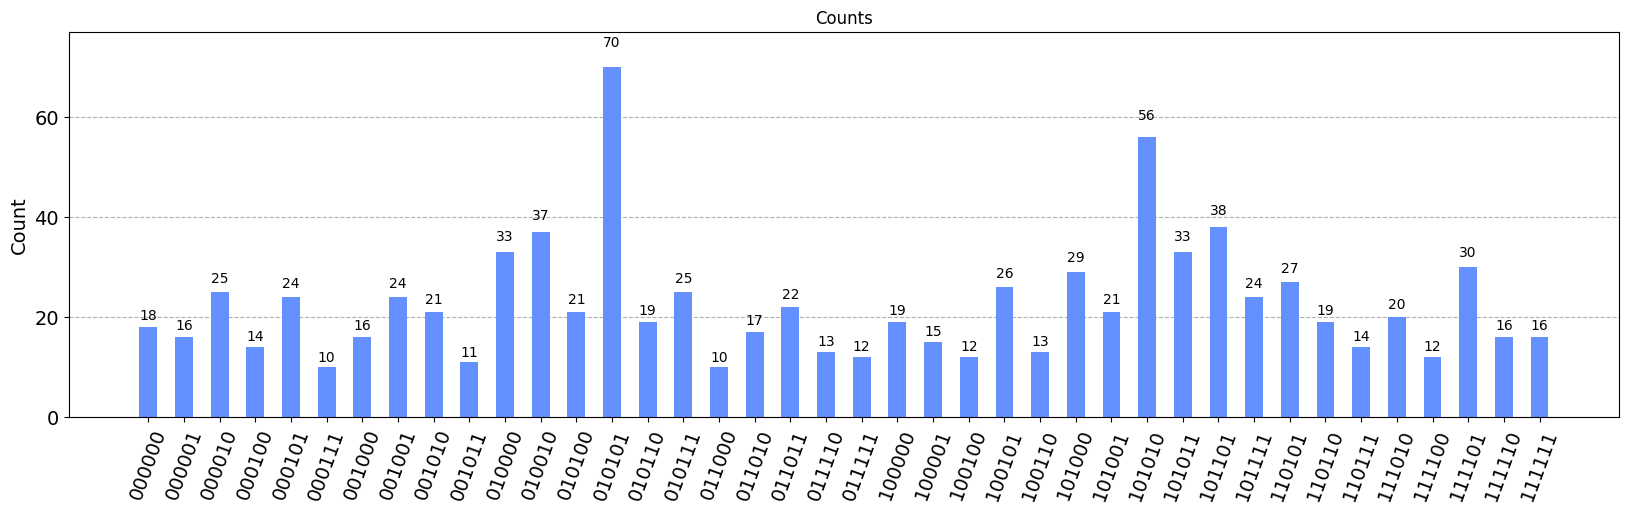

In [16]:
counts_6, hist_6 = qaoa(G6,3)
hist_6

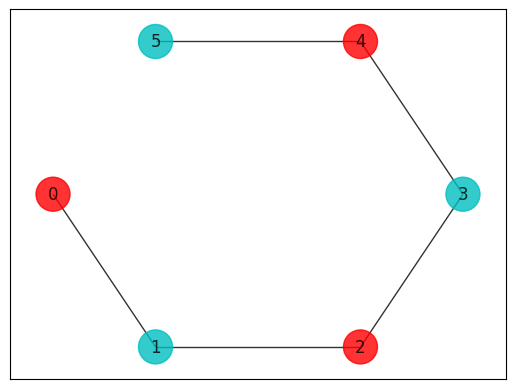

In [17]:
plot_solution(G6,pos6,counts_6)

### Graph with 7 nodes

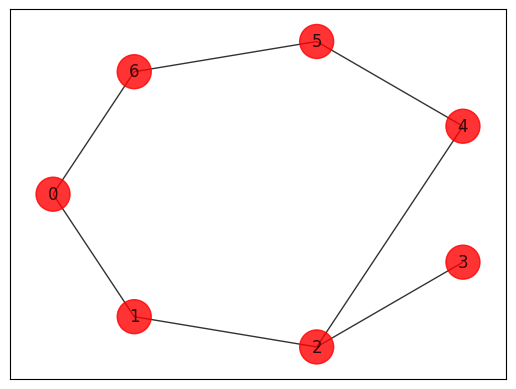

In [18]:
# Generating a graph of 7 nodes

# Defining the Graph.
# Nodes in the Graph.
n = 7  
G7 = nx.Graph()
G7.add_nodes_from(np.arange(0, n, 1))

# Edges in the Graph.
edges = [(0, 1, 1.0), (1, 2, 1.0), (2, 4, 1.0), (2, 3, 1.0), (4, 5, 1.0), (5, 6, 1.0), (0, 6, 1.0)]
G7.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G7.nodes()]
pos7 = nx.shell_layout(G7)

draw_graph(G7, colors, pos7)

Elapsed time for QAOA: 0.5197024345397949 seconds


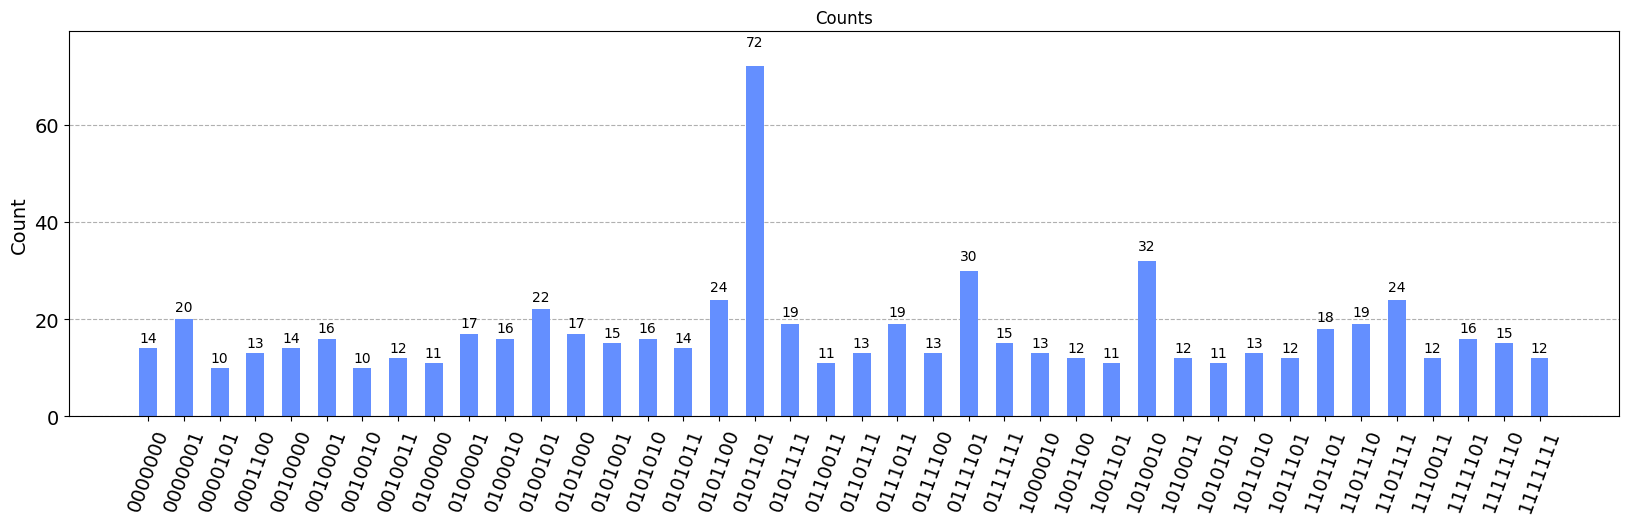

In [19]:
counts_7, hist_7 = qaoa(G7,3)
hist_7

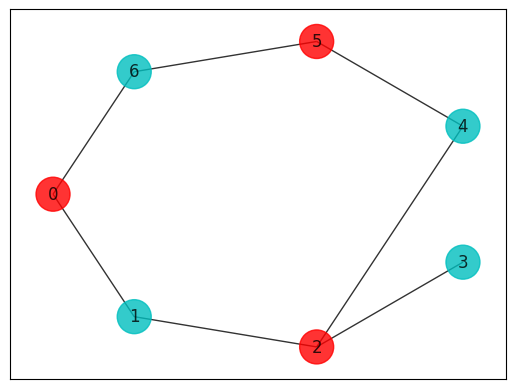

In [20]:
plot_solution(G7,pos7,counts_7)

## Drawing the QAOA circuit

(<Figure size 4300x600 with 1 Axes>, <Axes: >)

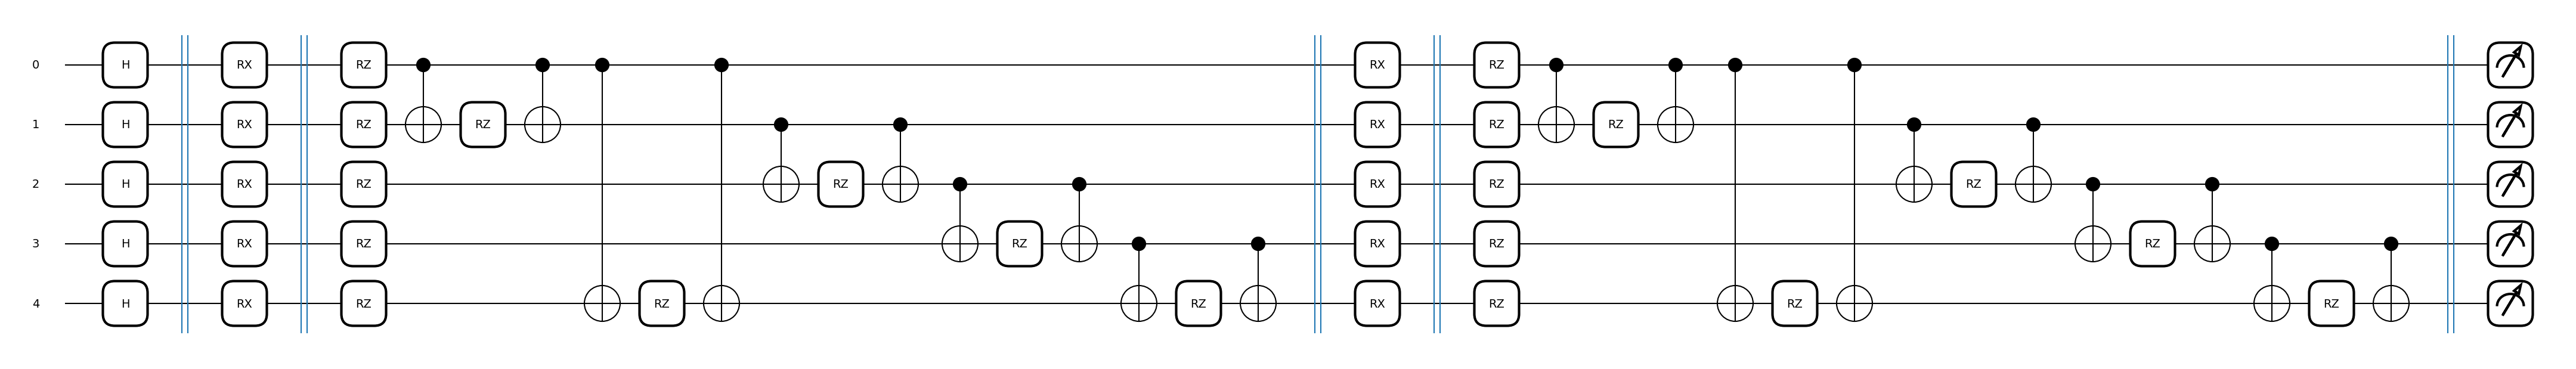

In [21]:
# Function to draw the QAOA circuit.
def draw_qaoa(G, layers):
    init_gamma = np.array([pi/2]*layers)
    init_beta = np.array([pi/4]*layers)
    quadratics, linears, qubo = build_qubo(G);

    num_qubits = G.number_of_nodes()

    dev = qml.device("lightning.qubit", wires=num_qubits, shots=1)
    @qml.qnode(dev)
    def circuit_draw(layers,gammas,betas,quadratics,linears):

        for qubit in range(num_qubits):
            qml.Hadamard(wires=qubit)
        qml.Barrier()

        for layer in range(layers):
            U_M(betas[layer],num_qubits)
            qml.Barrier()
            U_C(gammas[layer],quadratics,linears,num_qubits)
            qml.Barrier()
        
        return qml.counts(wires=range(num_qubits))

    return qml.draw_mpl(circuit_draw)(layers,init_gamma, init_beta, quadratics, linears)

draw_qaoa(G5, 2)